In [1]:
import sys
import matplotlib.pyplot as plt
import pandas

sys.path.append('/home/jshe/prop-pred/src/data')
from data_utils import *

import torch
import torch.nn as nn
import torch_geometric as torchg
import torch_geometric.nn as gnn
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_smiles

from rdkit.Chem import MolFromSmiles

#from gin import GIN

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%load_ext autoreload
%autoreload 2

## Data

In [2]:
datadir = '../../data/regress_immuno/'
data = to_namedtuple(to_tensor(load_data(datadir), device))

In [3]:
train_X = torch.concat((
    data.train.embeddings, 
    #data.train.fingerprints
), axis=1)
validation_X = torch.concat((
    data.validation.embeddings, 
    #data.validation.fingerprints
), axis=1)
test_X = torch.concat((
    data.test.embeddings, 
    #ata.test.fingerprints
), axis=1)

In [4]:
train_Y = torch.concat((
    data.train.y, 
    #data.train.y_rdkit, 
), axis=1)[:, 0].unsqueeze(-1)
validation_Y = torch.concat((
    data.validation.y, 
    #data.validation.y_rdkit
), axis=1)[:, 0].unsqueeze(-1)
test_Y = torch.concat((
    data.test.y, 
    #data.test.y_rdkit, 
), axis=1)[:, 0].unsqueeze(-1)

In [5]:
train_graphs = [from_smiles(smiles) for smiles in data.train.smiles]

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=False)

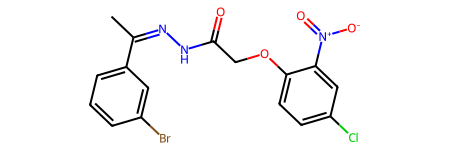

In [6]:
MolFromSmiles(data.train.smiles[0])

## Model

In [7]:
x = next(iter(train_loader)).to(device)

In [8]:
conv1 = gnn.GATv2Conv(
    in_channels=9, out_channels=256, 
    heads=1, dropout=0.4, edge_dim=3
).to(device)

In [9]:
embedding_dim = 16
attention_dim = 8

embed = nn.Linear(
    in_features=9, 
    out_features=embedding_dim, 
    bias=False
)

query = nn.Linear(
    in_features=9, 
    out_features=attention_dim, 
    bias=False
)

key = nn.Linear(
    in_features=9, 
    out_features=attention_dim, 
    bias=False
)

value = nn.Linear(
    in_features=9, 
    out_features=attention_dim, 
    bias=False
)

In [13]:
x.edge_index

sparse = torch.sparse_coo_tensor(
    indices=x.edge_index, 
    values=torch.ones(x.edge_index.shape[1]), 
    size=x.x.shape, 
    device=device
)

In [ ]:
sparse.long().to_dense()